In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
from tensorflow.contrib.metrics import f1_score as ms

tf.set_random_seed(1234)

In [2]:
#number of classes
num_labels = int(input("How many classes? "))

X_train = np.load('X_train_colour_non_6jun_300.npy')
y_train = np.load('y_train_colour_non_6jun_300.npy')
X_val = np.load('X_val_colour_non_6jun_300.npy')
y_val = np.load('y_val_colour_non_6jun_300.npy')
X_test = np.load('X_test_colour_non_6jun_300.npy')
y_test = np.load('y_test_colour_non_6jun_300.npy')

y_train = y_train.reshape(-1)
y_val = y_val.reshape(-1)
y_test = y_test.reshape(-1)

def reformat(dataset, labels, input_size, num_labels):
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

X_train, y_train = reformat(X_train, y_train, [500, 500, 1], num_labels)
X_val, y_val = reformat(X_val, y_val, [500, 500, 1], num_labels)
X_test, y_test = reformat(X_test, y_test, [500, 500, 1], num_labels)

# Calculate mean
train_mean = np.mean(X_train, axis=0)

# Calculate std
train_std = np.std(X_train, axis=0)

# Standardize data
X_train = np.divide((X_train - train_mean), train_std)
X_val = np.divide((X_val - train_mean), train_std)
X_test = np.divide((X_test - train_mean), train_std)

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

How many classes? 2
Training set (747, 300, 300, 1) (747, 2)
Validation set (218, 300, 300, 1) (218, 2)
Test set (130, 300, 300, 1) (130, 2)


In [3]:
regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

def weight_variable(layer_name,shape):
    return tf.get_variable(layer_name,shape=shape,initializer=tf.contrib.layers.xavier_initializer(seed=1234),regularizer=regularizer)

def bias_variable(layer_name,shape):
    return tf.Variable(tf.zeros(shape=shape),name=layer_name)

def conv_layer(inp, 
               layer_name_bias, 
               layer_name, 
               num_input_channels, 
               filter_size, 
               num_filters, 
               strides,
               ksize_maxpool, 
               kernel_regularizer=regularizer,
               pooling=True, 
               batchnorm=True, 
               dropout=True, 
               keep_prob=0.25):
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = weight_variable(layer_name, shape=shape)
    biases = bias_variable(layer_name_bias,shape=[num_filters])
    layer = tf.nn.conv2d(input=inp, filter=weights, strides=[1,strides,strides,1], padding="SAME")
    
    layer= tf.nn.bias_add(layer,biases)
    
    layer = tf.nn.relu(layer)

    if batchnorm:
        layer = tf.layers.batch_normalization(layer)
    
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1,ksize_maxpool,ksize_maxpool,1],
                               strides=[1,ksize_maxpool,ksize_maxpool,1],
                               padding='SAME')
    if dropout: 
        layer = tf.layers.dropout(layer, keep_prob)
        
    return layer, weights


def flatten_layer(layer):
    num_feat = np.prod(layer.get_shape().as_list()[1:4])
    layer = tf.contrib.layers.flatten(layer)
    
    return layer, num_feat


def fc_layer(input,
             layer_name_bias,
             layer_name,
             num_in,
             num_out,
             relu=True,
             batchnorm=True, 
             dropout=True, 
             keep_prob=0.5):
    
    weights = weight_variable(layer_name,shape=[num_in, num_out])
    biases = bias_variable(layer_name_bias,shape=[num_out])
    
    result = tf.add(tf.matmul(input,weights),biases)
    
    if relu:
        result = tf.nn.relu(result)
    
    if batchnorm:
        result = tf.layers.batch_normalization(result)
        
    if dropout: 
        result = tf.layers.dropout(result, keep_prob)
    
    return result


def softmax_function(input,num_in,num_out,weight_name):
    weights = weight_variable(weight_name,shape=[num_in, num_out])
    biases = bias_variable(shape=[num_out])
    result = tf.matmul(input,weights)+biases
    
    return result, weights


def global_pooling(layer,global_pooling='mean'):
    if global_pooling == 'mean':
        tf.reduce_mean(layer, [1, 2], name='global_pool', keep_dims=True)
    elif global_pooling == 'max':
        tf.reduce_max(layer, [1, 2], name='global_pool', keep_dims=True)

img_h = X_train.shape[1]
img_w = X_train.shape[2]

num_training_data = y_train.shape[0]


# Number of channels: 1 because greyscale
num_channels = 1

filter_size1 = 5
num_filters1 = 30
strides1 = 2
ksize_maxpool1 = 2

filter_size2 = 3
num_filters2 = 40
strides2 = 1
ksize_maxpool2 = 2

filter_size3 = 3
num_filters3 = 50
strides3 = 1
ksize_maxpool3 = 2

#number of neurons
fc_size=10

#l2 regularization
beta = 0.01

tf.reset_default_graph() 
batch = None

x = tf.placeholder(tf.float32, shape = (batch, img_h, img_w, num_channels),name='x')
y = tf.placeholder(tf.int32, shape = [batch,num_labels], name='y')
keep_prob = tf.placeholder(tf.float32)

conv1, weights1 = conv_layer(x,
                              layer_name='conv1',layer_name_bias='conv1_b',
                              num_input_channels=num_channels,
                              filter_size=filter_size1,
                              num_filters=num_filters1,
                              strides=strides1,
                              ksize_maxpool=ksize_maxpool1,
                              pooling=True,
                              batchnorm=True,
                              dropout=False,
                              keep_prob=keep_prob)

conv2, weights2 = conv_layer(conv1,
                              layer_name='conv2',layer_name_bias='conv2_b',
                              num_input_channels=num_filters1,
                              filter_size=filter_size2,
                              num_filters=num_filters2,
                              strides=strides2,
                              ksize_maxpool=ksize_maxpool2,
                              pooling=True,
                              batchnorm=True,
                              dropout=False,
                              keep_prob=keep_prob)

conv3, weights3 = conv_layer(conv2,
                              layer_name='conv3',layer_name_bias='conv3_b',
                              num_input_channels=num_filters2,
                              filter_size=filter_size3,
                              num_filters=num_filters3,
                              strides=strides3,
                              ksize_maxpool=ksize_maxpool3,
                              pooling=True,
                              batchnorm=True,
                              dropout=True,
                              keep_prob=keep_prob)

conv3 = tf.reduce_mean(conv3, [1, 2], name='global_pool', keep_dims=True)

flattened, num_features = flatten_layer(conv3)

fc1 = fc_layer(flattened,
               layer_name='fc1',layer_name_bias='fc1_b',
               num_in=num_filters3,
               num_out=fc_size,
               relu=True,
               batchnorm=True,
               dropout=True,
               keep_prob=keep_prob)

fc2 = fc_layer(fc1,
               layer_name='fc2',layer_name_bias='fc2_b',
               num_in=fc_size,
               num_out=num_labels,
               relu=False,
               batchnorm=False,
               dropout=True,
               keep_prob=keep_prob)

y_pred = tf.nn.softmax(fc2)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=fc2))

global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(0.07, global_step, 1000, 0.5, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


#batch norm
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
optimizer = tf.group([optimizer, update_ops])

correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


In [4]:
def create_minibatch(X,y,batch_size):
    
    num_training_data = y.shape[0]
    num_of_batches = num_training_data // batch_size
    minibatch = []
    
    for batch in range(num_of_batches):
        batch_data = X[batch*batch_size:(batch+1)*batch_size, :, :, :]
        batch_labels = y[batch*batch_size:(batch+1)*batch_size, :]
        minibatch.append((batch_data,batch_labels))
    
    if num_training_data % batch_size != 0:
        batch_data = X[num_of_batches*batch_size:num_training_data, :, :, :]
        batch_labels = y[num_of_batches*batch_size:num_training_data, :]
        minibatch.append((batch_data,batch_labels))
        
    return minibatch

def shuffle(x, y):
    """
    Shuffle data into random sequence

    Args:
        x (array): input data
        y (array): input label
    Returns:
        array: shuffled data and label
    """
    rand = np.random.permutation(len(x))
    x, y = x[rand], y[rand]
    return x, y

In [5]:
import time
import datetime

batch_size = 32
batch_size_val = 32
num_iterations = 70
eval_step = 2
rate = 0.1
dropout = 0.25

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

training_loss = []
training_acc = []
val_loss = []
val_acc = []
losses = 0
accs = 0

w_1 = []
w_2 = []
w_3 = []

l_rate=[]

saver = tf.train.Saver()

save_dir = r'C:\All Code\Work\CNN\Coloured_Tables_Detection\model'

# Create directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'coloured_detection')

# Start-time
start_time = time.time()

for epoch in range(num_iterations):
    X_train,y_train=shuffle(X_train,y_train)
    minibatches = create_minibatch(X_train,y_train,batch_size)
    
    X_val,y_val=shuffle(X_val,y_val)
    minibatches_val = create_minibatch(X_val,y_val,batch_size_val)
    
    if epoch % eval_step == 0:
        for minibatch in minibatches:
            (batch_data,batch_labels) = minibatch    
            feed_dict_train = {x: batch_data, y: batch_labels, keep_prob:dropout}
            _, acc, l = session.run([optimizer,accuracy,loss], feed_dict=feed_dict_train)
            losses = losses + (l*len(batch_labels))
            accs = accs + (acc*len(batch_labels))           
            
        losses = losses/y_train.shape[0]
        accs = accs/y_train.shape[0]
                           
        training_loss.append(losses)                        
        training_acc.append(accs)                     

        print('Training loss at epoch: %d is: %.4f' %  (epoch,training_loss[-1]))
        print('Training accuracy at epoch: %d is: %.4f' %  (epoch,training_acc[-1])) 

        accs=0
        losses=0
        
        for minibatch in minibatches_val:
            (val_data,val_labels) = minibatch    
            feed_dict_val = {x: val_data, y: val_labels, keep_prob: 1.0}
            acc, l = session.run([accuracy,loss], feed_dict=feed_dict_train)
            losses = losses + (l*len(val_labels))
            accs = accs + (acc*len(val_labels))    

        losses = losses/y_val.shape[0]
        accs = accs/y_val.shape[0]     
        
        val_loss.append(losses)                        
        val_acc.append(accs)                        
        
        print('Validation loss at epoch: %d is: %.4f' %  (epoch,val_loss[-1]))
        print('Validation accuracy at epoch: %d is: %.4f' %  (epoch,val_acc[-1]))
        print('\n')
    
        accs=0
        losses=0
        
    else:
        for minibatch in minibatches:
            (batch_data,batch_labels) = minibatch    
            feed_dict_train = {x: batch_data, y: batch_labels, keep_prob: dropout}
            session.run(optimizer, feed_dict=feed_dict_train)
    
    r = session.run(learning_rate)
    l_rate.append(r)
    print('Learning rate at epoch: %d is: %.4f' %  (epoch,l_rate[-1]))
            
saver.save(sess=session, save_path=save_path)
print('Model saved in file: {}'.format(save_path))
            
print('Average training accuracy is: %.4f' %  np.mean(training_acc))
print('Average training loss is: %.4f' %  np.mean(training_loss))

time_diff = time.time() - start_time
print('Elapsed Time: ', str(datetime.timedelta(seconds=time_diff)))

Training loss at epoch: 0 is: 0.6763
Training accuracy at epoch: 0 is: 0.5636
Validation loss at epoch: 0 is: 0.6701
Validation accuracy at epoch: 0 is: 0.7273


Learning rate at epoch: 0 is: 0.0700
Learning rate at epoch: 1 is: 0.0700
Training loss at epoch: 2 is: 0.6320
Training accuracy at epoch: 2 is: 0.6586
Validation loss at epoch: 2 is: 0.6113
Validation accuracy at epoch: 2 is: 0.5455


Learning rate at epoch: 2 is: 0.0700
Learning rate at epoch: 3 is: 0.0700
Training loss at epoch: 4 is: 0.5293
Training accuracy at epoch: 4 is: 0.7363
Validation loss at epoch: 4 is: 0.2677
Validation accuracy at epoch: 4 is: 0.9091


Learning rate at epoch: 4 is: 0.0700
Learning rate at epoch: 5 is: 0.0700
Training loss at epoch: 6 is: 0.4631
Training accuracy at epoch: 6 is: 0.7992
Validation loss at epoch: 6 is: 0.3751
Validation accuracy at epoch: 6 is: 0.8182


Learning rate at epoch: 6 is: 0.0700
Learning rate at epoch: 7 is: 0.0700
Training loss at epoch: 8 is: 0.3534
Training accuracy a

Training loss at epoch: 68 is: 0.0547
Training accuracy at epoch: 68 is: 0.9853
Validation loss at epoch: 68 is: 0.0013
Validation accuracy at epoch: 68 is: 1.0000


Learning rate at epoch: 68 is: 0.0350
Learning rate at epoch: 69 is: 0.0350
Model saved in file: C:\All Code\Work\CNN\Coloured_Tables_Detection\model\coloured_detection
Average training accuracy is: 0.9317
Average training loss is: 0.1742
Elapsed Time:  0:01:28.582505


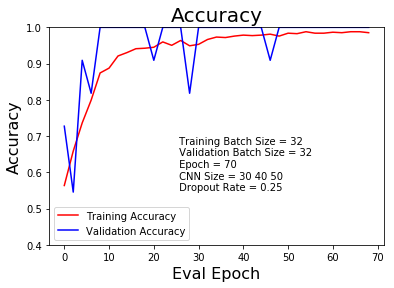

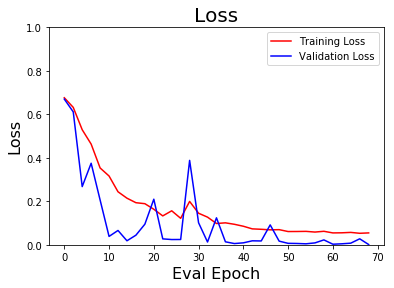

No handles with labels found to put in legend.


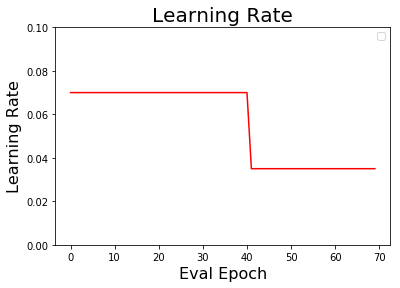

In [6]:
label = '\n Training Batch Size = %d \n Validation Batch Size = %d \n Epoch = %d \n CNN Size = %d %d %d \n Dropout Rate = %.2f' % (batch_size, batch_size_val, num_iterations, num_filters1, num_filters2, num_filters3, dropout)

plt.figure()
x_axis = np.arange(0,len(training_acc)*eval_step,eval_step)
plt.plot(x_axis,training_acc,color='red', label='Training Accuracy')
plt.plot(x_axis,val_acc,color='blue', label='Validation Accuracy')
plt.text(25, 0.55, label)
plt.title("Accuracy",fontsize=20)
plt.xlabel('Eval Epoch',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend(loc='best')
plt.ylim(0.4,1)
plt.savefig(os.path.join(save_dir,'accuracy.png'))
plt.show()

plt.figure()
plt.plot(x_axis,training_loss,color='red',label='Training Loss')
plt.plot(x_axis,val_loss,color='blue',label='Validation Loss')
plt.title("Loss",fontsize=20)
plt.xlabel('Eval Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend(loc='best')
plt.ylim(0,1)
plt.savefig(os.path.join(save_dir,'loss.png'))
plt.show()

plt.figure()
plt.plot(range(len(l_rate)),l_rate,color='red')
plt.title('Learning Rate',fontsize=20)
plt.xlabel('Eval Epoch',fontsize=16)
plt.ylabel('Learning Rate',fontsize=16)
plt.legend(loc='best')
plt.ylim(0,0.1)
plt.savefig(os.path.join(save_dir,'learning_rate.png'))
plt.show()



In [7]:
def predict_batch(X,Y,batch_size=64):

    output=[]
    accs=0
    with tf.Session() as session:

        saver.restore(session, save_path)
        minibatches = create_minibatch(X,Y,batch_size)
        for minibatch in minibatches:
            (batch_data,batch_labels) = minibatch    
            feed_dict = {x: batch_data, y: batch_labels, keep_prob: 1.0}
            acc, pred = session.run([accuracy,y_pred], feed_dict=feed_dict)
            pred = np.argmax(np.array(pred, copy=True),1)

            accs = accs + (acc*len(batch_labels))           
            output.append(pred)
            
        accs = accs/Y.shape[0]
        output = np.array(np.concatenate(output).ravel().tolist())
        y_cls=np.argmax(Y,1) 
        confusion=tf.confusion_matrix(y_cls,output)
        prec=tf.metrics.precision(y_cls,output)
        rec=tf.metrics.recall(y_cls,output)
        
        session.run(tf.global_variables_initializer())
        session.run(tf.local_variables_initializer())
        conf,prec0,rec0 = session.run([confusion,prec,rec])
        
        return accs,output,conf,prec0[0],rec0[0]

def precision(confusion,class_num):
    denom=0
    for i in range(confusion.shape[0]):
        denom+=confusion[i][class_num]   
    return confusion[class_num][class_num]/denom

def recall(confusion,class_num):
    denom=0
    for i in range(confusion.shape[0]):
        denom+=confusion[class_num][i]   
    return confusion[class_num][class_num]/denom

def f1_score(prec,rec):
    return 2*prec*rec/(prec+rec)

acc,output,conf,prec0,rec0 = predict_batch(X_test,y_test)
print('Accuracy test data: %.2f' % acc)
print('Confusion: \n', conf)

prec_0 = precision(conf,0)
prec_1 = precision(conf,1)


rec_0 = recall(conf,0)
rec_1 = recall(conf,1)


f1_0 = f1_score(prec_0,rec_0)
f1_1 = f1_score(prec_1,rec_1)

print('Class 0 - Coloured, precision: %.2f, recall: %.2f, F1_score: %.2f' %(prec_0,rec_0,f1_0))
print('Class 1 - Non-Coloured, precision: %.2f, recall: %.2f, F1_score: %.2f' %(prec_1,rec_1,f1_1))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\All Code\Work\CNN\Coloured_Tables_Detection\model\coloured_detection
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Accuracy test data: 0.98
Confusion: 
 [[63  2]
 [ 1 64]]
Class 0 - Coloured, precision: 0.98, recall: 0.97, F1_score: 0.98
Class 1 - Non-Coloured, precision: 0.97, recall: 0.98, F1_score: 0.98


true label:  0
predicted output:  1
(array([17, 18, 94], dtype=int64),)


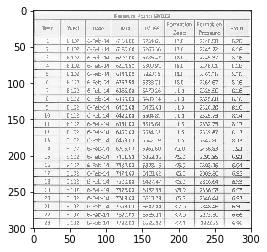

In [8]:
def plot_image(i,output,X,y):
    plt.imshow(np.squeeze(X[i]),cmap='gray')
    print('true label: ',np.argmax(y[i]))
    print('predicted output: ', output[i])
    print(np.where((output != np.argmax(y,1))))    

plot_image(18,output,X_test,y_test)

In [295]:
from PIL import Image
import shutil

img_w = 300
img_h = 300

def resize_and_create_array(filepath):
    
    num_files = sum([len(files) for r, d, files in os.walk(filepath)])
    root = [root for root, folder, files in os.walk(filepath)][0]
    X_pred = np.zeros(shape=(num_files, img_h, img_w), dtype='uint8')
    
    i=0
    for root,folder,files in os.walk(filepath):
        for file in files[:]:
            file=file.lower()
            path = os.path.join(root,file)
            if '.png' not in path:
                continue
            try:
                img = Image.open(path).convert('L')
                img = np.array(img.resize((int(img_w),int(img_h))))
                X_pred[i]=img
                i+=1
            except:
                print(file)
    
    X_pred= np.reshape(X_pred,(-1, img_h, img_w,1))
    X_pred = np.divide((X_pred - train_mean), train_std)
    return X_pred
                
    
def create_minibatch_pred(X,batch_size=1000):
    
    num_training_data = X.shape[0]
    num_of_batches = num_training_data // batch_size
    minibatch = []
    
    for batch in range(num_of_batches):
        batch_data = X[batch*batch_size:(batch+1)*batch_size, :, :, :]
        minibatch.append(batch_data)
    
    if num_training_data % batch_size != 0:
        batch_data = X[num_of_batches*batch_size:num_training_data, :, :, :]
        minibatch.append(batch_data)
        
    return minibatch


def predict_batch_2(X,batch_size=1000):
    output=[]
    accs=0
    with tf.Session() as session:
        print(save_path)
        saver.restore(session, save_path)
        minibatches = create_minibatch_pred(X,batch_size)
        for minibatch in minibatches:
            batch_data = minibatch    
            feed_dict = {x: batch_data, keep_prob: 1.0}
            pred = session.run(y_pred, feed_dict=feed_dict)
            pred = np.argmax(np.array(pred, copy=True),1)         
            output.append(pred)
            
        output = np.array(np.concatenate(output).ravel().tolist())
        return output
    
    
def binning_pred(output):
    files = [files for root, folder, files in os.walk(filepath)][0]
    root = [root for root, folder, files in os.walk(filepath)][0]
    
    num_class = len(np.unique(output))
    
    i=0
    for value in output:
        path = os.path.join(root,files[i])
        out_folder = 'class_'+str(value)
        outdir = os.path.join(root,out_folder)
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        shutil.copy(path,outdir)
        i+=1
            
def main_predict():
    start_time = time.time()
    X_pred = resize_and_create_array(filepath)
    print('Pred set', X_pred.shape)
    output = predict_batch_2(X_pred)
    binning_pred(output)
    time_diff = time.time() - start_time
    print('Prediction Done! Elapsed Time: ', str(datetime.timedelta(seconds=time_diff)))
    
filepath = input("Prediction Data Path: ")
main_predict()

Prediction Data Path: D:\Table_Structure_Classification\Data_4_June\all_data\colour_non_colour\all_data\new_set\prediction
Pred set (46, 300, 300, 1)
D:\Table_Structure_Classification\model_colour\table_structure
INFO:tensorflow:Restoring parameters from D:\Table_Structure_Classification\model_colour\table_structure
Prediction Done! Elapsed Time:  0:00:01.553392
